In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch,torchvision, time, copy
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

from PIL import Image
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms


In [3]:
torch.manual_seed(40)
cudnn.deterministic=True
cudnn.benchmark=False
device = torch.device("mps" if torch.mps.is_available else "cpu")

In [4]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406], # using ImageNet stats
            std  = [0.229, 0.224, 0.225]
        )
    ]),
    
    "test": transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std  = [0.229, 0.224, 0.225]
        )
    ])
}

In [5]:
data_dir = "/Users/lavanyanew/DataspellProjects/Learning_PyTorch/data/muffinvschihuahua"
image_datasets = {
    split_data: datasets.ImageFolder(
        root=f"{data_dir}/{split_data}",
        transform= data_transforms[split_data]
    )
    for split_data in ["train", "test"]
}

dataloaders = {
    split_data: torch.utils.data.DataLoader(
        image_datasets[split_data],
        batch_size=4,
        shuffle=(split_data=="train"),
        num_workers=0
    )
    for split_data in ["train", "test"]
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}



In [6]:
model_ft = models.resnet18(weights=True)
num_ftrs = model_ft.fc.in_features

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimiser_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimiser_ft, step_size=7, gamma=0.1)


/Users/lavanyanew/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([1, 1, 1, 1])


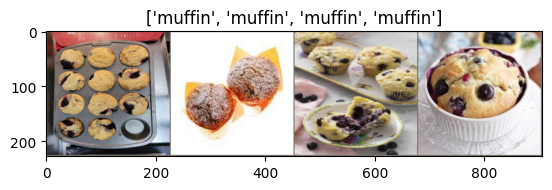

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    
    if title: plt.title(title)
    
    plt.pause(0.001)
        
inputs, classes = next(iter(dataloaders["train"]))
print(classes)
out = torchvision.utils.make_grid(inputs)
class_names = image_datasets["train"].classes
imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimiser, scheduler, num_epochs=8):
    since = time.time()
    
    # create a deep copy of the model provided
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch}/{num_epochs-1}")
        print("-"*10)
        
        for phase in ["train", "test"]:
            if phase == "train": model.train()
            else: model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # reset the parameter gradients
                optimiser.zero_grad()
                
                # forward pass
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
                    
                    # backward pass
                    if phase == "train":
                        loss.backward()
                        optimiser.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == "train":
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == "test" and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print(f"Training completed in: {time_elapsed // 60:.0f} mins and {time_elapsed % 60:.0f} secs")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    
    model.load_state_dict(best_model_weights)
    return model
                
                
                

In [10]:
def visualise_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [11]:
model = train_model(model_ft, criterion, optimiser_ft, exp_lr_scheduler)

Epoch: 0/7
----------
train Loss: 0.4986 Acc: 0.8707
test Loss: 0.1198 Acc: 0.9713

Epoch: 1/7
----------
train Loss: 0.2070 Acc: 0.9138
test Loss: 0.0852 Acc: 0.9780

Epoch: 2/7
----------
train Loss: 0.1771 Acc: 0.9263
test Loss: 0.0623 Acc: 0.9840

Epoch: 3/7
----------
train Loss: 0.1702 Acc: 0.9301
test Loss: 0.0513 Acc: 0.9848

Epoch: 4/7
----------
train Loss: 0.1559 Acc: 0.9320
test Loss: 0.0380 Acc: 0.9890

Epoch: 5/7
----------
train Loss: 0.1345 Acc: 0.9472
test Loss: 0.0341 Acc: 0.9882

Epoch: 6/7
----------
train Loss: 0.1204 Acc: 0.9518
test Loss: 0.0383 Acc: 0.9890

Epoch: 7/7
----------
train Loss: 0.1101 Acc: 0.9531
test Loss: 0.0294 Acc: 0.9899

Training completed in: 15 mins and 33 secs
Best Accuracy: 0.9899


In [ ]:
torch.save(model_ft.state_dict(), "../model.pth")